In [69]:
from astropy.table import Table, Column
import numpy as np
from numpy.linalg import inv 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
import urllib.request
import corner
import emcee

In [70]:
os.chdir("/Users/Roberto Benard Orci/Documents/Python Scripts")
os.getcwd()

'C:\\Users\\Roberto Benard Orci\\Documents\\Python Scripts'

In [71]:
Table1 = np.loadtxt(fname = "/Users/Roberto Benard Orci/Documents/Python Scripts/Table1.txt")

column_names = ['ID', 'x', 'y','Sigma y', 'Sigma x', 'Rho xy']

#Table1 = pd.DataFrame(Table1, columns=column_names)

In [72]:
b = 213.2734919759614
m = 1.0767475241683222

print(m,b)

1.0767475241683222 213.2734919759614


In [73]:
def f(t):
    return t*m +b

t3 = np.arange(0.0, 300.0, 0.1)
t4 = np.arange(0.0, 300.0, 0.02)

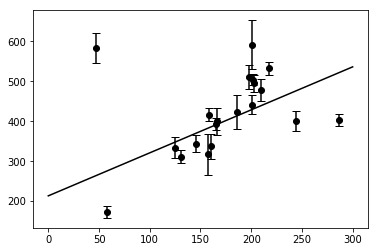

In [74]:
error = Table1[:,3]
plt.errorbar(Table1[:,1], Table1[:,2], yerr=error, fmt='ko',capsize=4)
plt.plot(t4, f(t4), 'k')

In [75]:
N = np.size(Table1[:,0])
x = Table1[:,1]
yerr = Table1[:,3]
y = Table1[:,2]

In [86]:
LSm = 1.0767475241683222
LSb = 213.2734919759614

m_true = 2.2
b_true = 34
#f_true = 0.534     What is this value????????????

Pb = 0.2
Yb = np.mean([Table1[0,2],Table1[1,2],Table1[2,2],Table1[3,2]])
Vb = np.mean([Table1[0,3],Table1[1,3],Table1[2,3],Table1[3,3]])

print(Vb,Yb)

34.75 494.5


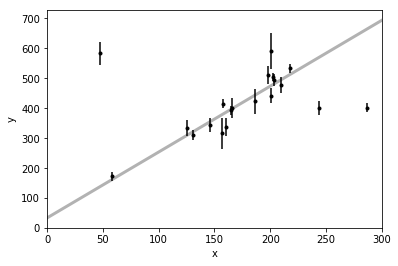

In [77]:
# "true" model

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 300, 500)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 300)
plt.xlabel("x")
plt.ylabel("y");

In [78]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    sigma3 = Vb + yerr**2
    return -0.5*np.sum(0.8*((y-model)**2/sigma2 + np.log(np.sqrt(2*np.pi*sigma2))) + 0.2*((y-Yb)**2/sigma3 + 
        np.log(np.sqrt(2*np.pi*sigma3))))

def log_prior(theta):
    m, b = theta
    if 0.0 < m < 5.0 and 0.0 < b < 50.0 :
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Maximum likelihood estimates:
m = 1.077
b = 213.274


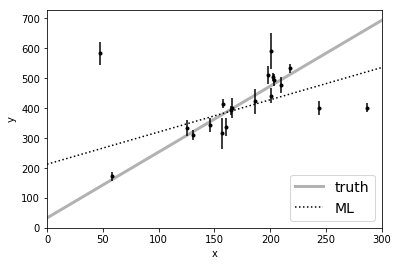

In [79]:
from scipy.optimize import minimize
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true])
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

def f(t):
    return t*LSm +LSb

t3 = np.arange(0.0, 300.0, 0.1)
t4 = np.arange(0.0, 300.0, 0.02)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
#plt.plot(x0, f(x0), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 300)
plt.xlabel("x")
plt.ylabel("y");

Maximum likelihood estimates:
m = 1.989
b = 33.999


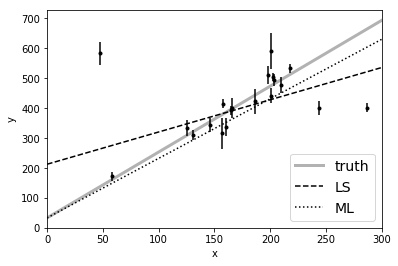

In [80]:
nll = lambda *args: -log_probability(*args)
initial = np.array([m_true, b_true])
soln = minimize(nll, initial, args=(x, y, yerr))
m_ML, b_ML = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ML))
print("b = {0:.3f}".format(b_ML))

def f(t):
    return t*LSm +LSb

t3 = np.arange(0.0, 300.0, 0.1)
t4 = np.arange(0.0, 300.0, 0.02)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, f(x0), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ML, b_ML]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 300)
plt.xlabel("x")
plt.ylabel("y");

In [81]:
pos = soln.x + 1e-4*np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000);

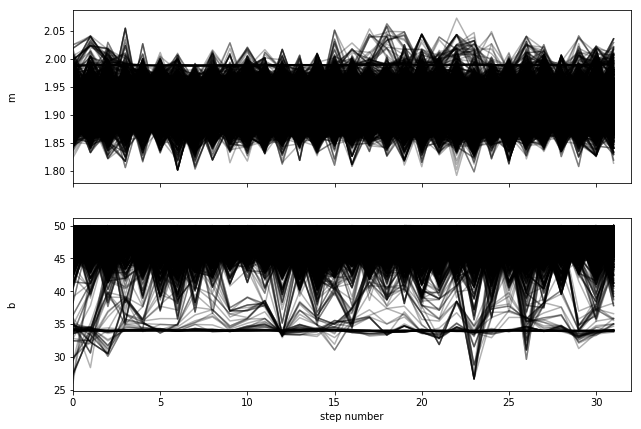

In [82]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [83]:
#tau = sampler.get_autocorr_time()
#print(tau)

In [84]:
flat_samples = np.concatenate(sampler.chain)
                                                # sampler.chain[:,1000:,:] Burns cerntain data
print(flat_samples.shape)

(160000, 2)


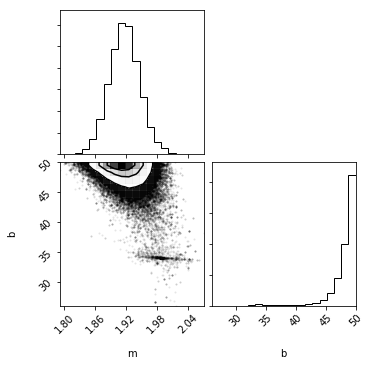

In [85]:
fig = corner.corner(flat_samples, labels=labels);